# Generative Learning Using a Quantum Computer

In this tutorial, we implement Data-driven quantum circuit learning (DDQCL), based on the 2019 paper [Training of quantum circuits on a hybrid quantum computer](https://advances.sciencemag.org/content/5/10/eaaw9918) by Zhu et. al, using the Qiskit SDK.

### DQCCL
DDQCL is a hybrid quantum-classical technique for generative modeling of classical data, using a parametrized quantum circuit as the model being trained. Training occurs by sampling the output of a parametrized circuit run on a quantum computer and updating the circuit parameters using classical optimization techniques. Convergence produces a circuit that captures the correlations in the training data, thus serving as a generative model for the data itself.

### The Bars-And-Stripes (BAS) Dataset
The data we will be training against is a canonical ensemble that works like so: for an $n \times m$ matrix, each cell can either be on (filled-in) or off (blank); it is a valid BAS example if it contains only completely filled rows (bars) or columns (stripes).

For a 2x2 matrix, like we will be using in this example, this allows for six valid patterns of 16 total permutations:
![BAS.png](attachment:c0eeb85b-c61f-404b-8d44-98dade577195.png)

We encode this as a binary string by reading left-to-right, top-to-bottom, with a filled-in cell representing a 1 and a blank cell a 0; the above valid examples translate (in order) to 0000, 1100, 0011, 0000, 1010, and 0101.

## Implementation
We will be implementing this technique using noisyopt, a python library for optimizing noisy functions. To do that, we'll need to define
1. A generator for our BAS training data
2. A generator for our parametrized circuit
3. A cost function for our optimizer
4. The hybrid learning algorithm itself, using all of the above

## Imports and Setup

First, we'll do some setup that will allow us to build, optimize, visualize, store, and retrieve the circuits we'll be running.

First, get an API key from IonQ. This will be used by the IonQ provider inside Qiskit to submit circuits to the IonQ platform.

After securing an API key, install the qiskit-ionq provider at https://github.com/Qiskit-Partners/qiskit-ionq/

### (Optional) Extra Dependencies

Some examples use additional Python dependencies; please make sure to `pip install` them as needed.

Dependencies:
* `matplotlib`: To run `qiskit.visualization.plot_histogram`.

**NOTE**: The provider expects an API key to be supplied via the `token` keyword argument to its constructor. If no token is directly provided, the provider will check for one in the `QISKIT_IONQ_API_TOKEN` environment variable.

Now that the Python package has been installed, you can import and instantiate the provider:

In [7]:
!python -m pip install -U pip
!python -m pip install -U "qiskit-terra>=0.17.4"
!python -m pip install qiskit-ionq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: decorator
    Found existing installation: decorator 4.4.2
    Uninstalling decorator-4.4.2:
      Successfully uninstalled decorator-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
moviepy 1.0.3 requires decorator<5.0,>=4.0.2, but you have decorator 5.1.1 which is incompatible.


In [8]:
# general imports
import math
import time
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from datetime import datetime

# Noisy optimization package — you could also use scipy's optimization functions,
# but this is a little better suited to the noisy output of NISQ devices.
%pip install noisyopt
import noisyopt

# magic invocation for producing visualizations in notebook
%matplotlib inline

In [9]:
# Qiskit imports
from qiskit import Aer

from qiskit_ionq import IonQProvider

#Call provider and set token value
provider = IonQProvider(token='hoE6a1L4O41FK0m4PHPtLu5kLxj6Jl6R')

The `provider` instance can now be used to create and submit circuits to IonQ.

### Backend Types

The IonQ provider supports two backend types:
* `ionq_simulator`: IonQ's simulator backend.
* `ionq_qpu`: IonQ's QPU backend.

To view all current backend types, use the `.backends` property on the provider instance:


In [10]:
provider.backends()

[<IonQSimulatorBackend('ionq_simulator')>, <IonQQPUBackend('ionq_qpu')>]

In [11]:
# fix random seed for reproducibility — this allows us to re-run the process and get the same results
seed = 42
np.random.seed(seed)
random.seed(a=seed)

## BAS Generator

Here we generate our bars and stripes — as this is just a proof-of-principle, we are limiting the possible outputs to the four single-bar or single-stripe outputs to keep convergence time (and therefore training cost) low.

In [12]:
#Generate BAS, only one bar or stripe allowed
def generate_target_distribution(rows, columns):
    #Stripes
    states=[]
    for i in range(rows):
        s=['0']*rows*columns
        for j in range(columns):
            s[j+columns*i]='1'
        states.append(''.join(s))

    #Bars
    for j in range(columns):
        s=['0']*rows*columns
        for i in range(rows):
            s[j+columns*i]='1'
        states.append(''.join(s))

    return states
###def

## Circuit Generator

Here we define several driver functions which consist of parametrized one qubit gates that help to explore the Hilbert space, and several entangler functions that generate entanglement in the system.

The complete circuit ansatz consists of repeating layers of the drivers and entanglers. The parameters ($\gamma$ and $\beta$) of the ansatz are iteratively optimized (learned) by our hybrid quantum-clasical routine.

In [14]:
#Parameters for driver
def generate_beta(ansatz_type,random_init):
    if ansatz_type[0]==0: #No driver
        beta=[]
    elif ansatz_type[0]==1: #Rz(t1)Rx(t2)Rz(t3), angles different for each qubit
        beta=(
            [random.uniform(0.0,2.*math.pi) for i in range(3*n*(layers-1))]
            if random_init
            else [0]*3*n*(layers-1)
            ###if
        )
    elif ansatz_type[0]==2: #Rz(t1)Rx(t2)Rz(t3), angles same for all qubits
        beta=(
            [random.uniform(0.0,2.*math.pi) for i in range(3*(layers-1))]
            if random_init
            else [0]*3*(layers-1)
            ###if
        )
    elif ansatz_type[0]==3: #Rz(t1), angles different for each qubit
        beta=(
            [random.uniform(0.0,2.*math.pi) for i in range(n*(layers-1))]
            if random_init
            else [0]*n*(layers-1)
            ###if
        )
    else:
        raise Exception("Undefined driver type")
    ###if

    return beta
###def

#Parameters for entangler
def generate_gamma(ansatz_type,random_init, n, conn):
    length_gamma=int(n*conn-conn*(conn+1)/2.)
    if ansatz_type[1]==0: #No entangler
        gamma=[]
    elif ansatz_type[1]==1: #XX(t1), angles different for each qubit
        gamma=(
            [random.uniform(0.0,2.*math.pi) for i in range(length_gamma*layers)]
            if random_init
            else [0]*length_gamma*layers
            ###if
        )
    elif ansatz_type[1]==2: #XX(t1), angles same for all qubits
        gamma=(
            [random.uniform(0.0,2.*math.pi) for i in range(layers)]
            if random_init
            else gamma[0]*layers
            ###if
        )
    else:
        raise Exception("Undefined entangler type")
    ###if

    return gamma
###def


In [15]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Gate

def driver(circ,qr,beta,n,ansatz_type):
    #qr=QuantumRegister(n)
    #circ = QuantumCircuit(qr)

    if ansatz_type==0:
        pass
    elif ansatz_type==1:
        for i_q in range(n):
            circ.rz(beta[3*i_q], qr[i_q])
            circ.rx(beta[3*i_q+1], qr[i_q])
            circ.rz(beta[3*i_q+2], qr[i_q])
        ###for
    elif ansatz_type==2:
        for i_q in range(n):
            circ.rz(beta[0], qr[i_q])
            circ.rx(beta[1], qr[i_q])
            circ.rz(beta[2], qr[i_q])
        ###for
    elif ansatz_type==3:
        for i_q in range(n):
            circ.rz(beta[i_q], qr[i_q])
        ###for
    ###if

    return
###def

def entangler(circ,qr,gamma,n,conn,ansatz_type):
    #qr=QuantumRegister(n)
    #cr=ClassicalRegister(n)
    #circ = QuantumCircuit(qr)

    if ansatz_type==0:
        pass
    elif ansatz_type==1:
        i_gamma=0
        for i_conn in range(1,conn+1):
            for i_q in range(0,n-i_conn):
                circ.cx(qr[i_q],qr[i_q+i_conn])
                circ.rx(gamma[i_gamma],qr[i_q])
                circ.cx(qr[i_q],qr[i_q+i_conn])
                #circ.rxx(gamma[i_gamma], qr[i_q], qr[i_q+i_conn])
                i_gamma+=1
            ###for
        ###for
    elif ansatz_type==2:
        for i_conn in range(1,conn+1):
            for i_q in range(0,n-i_conn):
                circ.cx(qr[i_q],qr[i_q+i_conn])
                circ.rx(gamma[0],qr[i_q])
                circ.cx(qr[i_q],qr[i_q+i_conn])
                #circ.rxx(gamma[0], qr[i_q], qr[i_q+i_conn])
            ###for
        ###for
    ###if

    #circ.measure(qr,cr)
    return
###def

#Define circuit ansatz
def circuit_ansatz(n,params,conn=1, layers=1, ansatz_type=[1,1]):
    qr=QuantumRegister(n)
    cr=ClassicalRegister(n)
    circ = QuantumCircuit(qr,cr)
    if ansatz_type[0]==0:
        length_beta=0
    elif ansatz_type[0]==1:
        length_beta=3*n
    elif ansatz_type[0]==2:
        length_beta=3
    elif ansatz_type[0]==3:
        length_beta=n
    ###if

    if ansatz_type[1]==0:
        length_gamma=0
    elif ansatz_type[1]==1:
        length_gamma=int(n*conn-conn*(conn+1)/2.)
    elif ansatz_type[1]==2:
        length_gamma=1
    ###if


    for i_layer in range(layers-1):
        beta=params[(length_beta+length_gamma)*i_layer:(length_beta+length_gamma)*i_layer+length_beta]
        gamma=params[(length_beta+length_gamma)*i_layer+length_beta:(length_beta+length_gamma)*(i_layer+1)]
        entangler(circ,qr,gamma,n,conn,ansatz_type[1])
        driver(circ,qr,beta,n,ansatz_type[0])
    ###for

    gamma=params[(length_beta+length_gamma)*(layers-1):]
    entangler(circ,qr,gamma,n,conn,ansatz_type[1])
    circ.measure(qr, cr)

    return circ
###def

## Cost function

Here, we define our cost function to feed to the optimization routine, which takes the form of a regularized Kullback-Leibler Divergence ([Quick Overview](https://medium.com/@cdefaux/kullback-leibler-divergence-for-dummies-c3613bc80ad3), [Wikipedia](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)).

In [16]:
def cost(counts, shots, target_states,tol=0.0001):
    cost=0
    for state in target_states:
        if state in counts:
            cost-=1./len(target_states)*np.log2(max(tol,counts[state]/shots))
        else:
            cost-=1./len(target_states)*np.log2(tol)
        ###if
    ###for
    return cost
###def

## Helper Methods

Finally, we define two helper methods: `run_iteration`, to run and return each iteration of our circuit (with some helpful tools for managing timeouts and waiting for results) and `run_circuit_and_calc_cost`, which  uses `run_iteration` to both run an interation of the circuit and calculate a new cost function, effectively taking a training step.

In [18]:
from qiskit.providers.jobstatus import JobStatus

def run_iteration(circ, num_qubits, shots=100):
    # submit task: define task (asynchronous)
    task_status=''
    while task_status != JobStatus.DONE:

            task = backend.run(circ, shots=shots)
            #print("Job submitted")

            # Get ID of submitted task
            task_id = task.job_id()
            #print('Task ID :', task_id)
            while (task_status == JobStatus.INITIALIZING) or (task_status == JobStatus.QUEUED)   or (task_status == JobStatus.VALIDATING) or (task_status == JobStatus.RUNNING) or (task_status==''):
                time.sleep(1)
                try:
                    task_status=task.status()
                except:
                    print("Error querying status. Trying again.")
                    pass
                ###try
            ###while
        #print('Task status is', task_status)
    ###while

    # get result
    counts = task.result().get_counts()

    return counts
###def


#Run an iteration of the circuit and calculate its cost
def run_circuit_and_calc_cost(params, *args):
    n, conn, layers, ansatz_type, target_states, shots = args
    circ=circuit_ansatz(n, params, conn, layers,ansatz_type)
    counts=run_iteration(circ, n, shots=shots)
    iter_cost=cost(counts, shots, target_states)
    cost_history.append(iter_cost)
    print("Current cost:", iter_cost)
    return iter_cost
###def

# Running The Learning Algorithm

Now we're ready to run the learning algorithm and train our circuit.

### Choose Target Device

We need to do this first because we check against its capabilities when building the training data and circuit. We do not recommend running this this algorithm against a real hardware device until you have run it on a simulator to understand estimated price and if it will converge with the parameters you've selected.

So first, let's test it on the simulator

In [19]:
backend = provider.get_backend("ionq_simulator")

### Set Up Training Data

First, we'll set up our training data for the problem using the method we defined earlier.

In [20]:
#Set problem parameters
r=2 #Number of rows — make sure r*c is less than qubit count
c=2 #Number of columns — make sure r*c is less than qubit count
n=r*c #Qubits needed
conn=2 #Connectivity of the entangler.

#Check on qubit count
if n>backend.configuration().n_qubits:
    raise Exception("Too many qubits")
###if

#Check on conn
if conn>(n-1):
    raise Exception("Connectivity is too large")
###if

target_states=generate_target_distribution(r,c)

# Check expected output
print('Bitstrings that should be generated by trained circuit are', target_states, 'corresponding to the following BAS patterns:\n')
for state in target_states:
    for i in range(r):
        print(state[c*i:][:c].replace('0','□ ').replace('1','■ '))
    ###for
    print('')
###for

Bitstrings that should be generated by trained circuit are ['1100', '0011', '1010', '0101'] corresponding to the following BAS patterns:

■ ■ 
□ □ 

□ □ 
■ ■ 

■ □ 
■ □ 

□ ■ 
□ ■ 



### Set Up Training Parameters
Now, we'll set up our parameters for the training routine itself — these are all tunable; feel free to play with them to see how they impact the routine (especially when running on a local simulator!). Again, because this is just a proof-of-principle demo, we've selected some defaults that keep convergence time and training cost low.

In [21]:
# Choose entangler and driver type
layers=1 # Number of layers in each circuit
shots=100 # Number of shots per iteration
ansatz_type=[1,1]
random_init=False # Set to true for random initialization; will be slower to converge

# Set up args
beta=generate_beta(ansatz_type, random_init)
gamma=generate_gamma(ansatz_type, random_init, n, conn)
params=beta+gamma

base_bounds=(0,2.*math.pi)
bnds=((base_bounds , ) * len(params))

#Set up list to track cost history
cost_history=[]

max_iter=100 # max number of optimizer iterations

args=(n, conn, layers, ansatz_type, target_states, shots)
opts = {'disp': True, 'maxiter': max_iter, 'maxfev': max_iter, 'return_all': True}

#Visualize the circuit
circ=circuit_ansatz(n, params, conn,layers,ansatz_type)
circ.draw()

┌───────┐                                                ┌───────┐»
q0_0: ──■──┤ Rx(0) ├──■──────────────────────────────────────────■──┤ Rx(0) ├»
      ┌─┴─┐└───────┘┌─┴─┐     ┌───────┐                          │  └───────┘»
q0_1: ┤ X ├─────────┤ X ├──■──┤ Rx(0) ├──■───────────────────────┼──────■────»
      └───┘         └───┘┌─┴─┐└───────┘┌─┴─┐     ┌───────┐     ┌─┴─┐    │    »
q0_2: ───────────────────┤ X ├─────────┤ X ├──■──┤ Rx(0) ├──■──┤ X ├────┼────»
                         └───┘         └───┘┌─┴─┐└───────┘┌─┴─┐└───┘  ┌─┴─┐  »
q0_3: ──────────────────────────────────────┤ X ├─────────┤ X ├───────┤ X ├──»
                                            └───┘         └───┘       └───┘  »
c0: 4/═══════════════════════════════════════════════════════════════════════»
                                                                             »
«                         ┌─┐         
«q0_0: ───────────■───────┤M├─────────
«      ┌───────┐  │       └╥┘┌─┐      
«q0_1: ┤ Rx(0) ├──┼────■───╫─┤M├──────
«      └───────┘┌─┴─┐  │   ║ └╥┘┌─┐   
«q0_2: ─────────┤ X ├──┼───╫──╫─┤M├───
«               └───┘┌─┴─┐ ║  ║ └╥┘┌─┐
«q0_3: ──────────────┤ X ├─╫──╫──╫─┤M├
«                    └───┘ ║  ║  ║ └╥┘
«c0: 4/════════════════════╩══╩══╩══╩═
«                          0  1  2  3

Current cost: 13.287712379549449
Current cost: 4.2328921423310435
Current cost: 7.805723050606501
Current cost: 3.8022756362132704
Current cost: 4.020892915692306
Current cost: 10.121156378848655
Current cost: 2.306319943871599
Current cost: 8.385302260940247
Current cost: 2.4684280475397893
Current cost: 5.84188297686439
Current cost: 7.461582212740448
Current cost: 2.2947969806928197
Current cost: 3.304330762914513
Current cost: 6.277689123023864
Current cost: 4.086651517150754
Current cost: 3.2437618014977634
Current cost: 4.343938103565633
Current cost: 2.5626704121511206
Current cost: 2.5384550273379736
Current cost: 3.9901787287459225
Current cost: 4.270892915692306
Current cost: 2.529446844526784
Current cost: 3.033801107796137
Current cost: 2.7723045564775917
Current cost: 3.156035011032982
Current cost: 2.9898625877350096
Current cost: 2.9253269761635967
Current cost: 2.9114028936086873
Current cost: 2.7961292266437026
Current cost: 3.1904108919704655
Current cost: 2.926265009

Text(0.5, 0, 'Iteration')

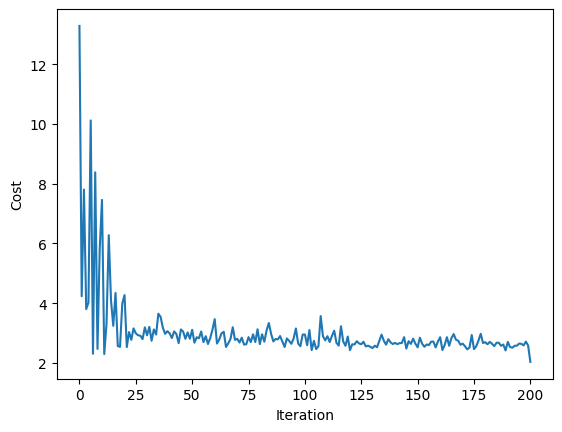

In [22]:
from qiskit.visualization import plot_histogram

#Train Circuit
result=noisyopt.minimizeSPSA(run_circuit_and_calc_cost, params, args=args, bounds=bnds, niter=max_iter, disp=False, paired=False)

print("Success: ", result.success)
print(result.message)
print("Final cost function is ", result.fun)
print("Min possible cost function is ", np.log2(len(target_states)))
print("Number of iterations is ", result.nit)
print("Number of function evaluations is ", result.nfev)
print("Number of parameters was ", len(params))
print("Approximate cost on hardware: $", 0.01*len(cost_history)*shots)

#Plot the evolution of the cost function
plt.figure()
plt.plot(cost_history)
plt.ylabel('Cost')
plt.xlabel('Iteration')


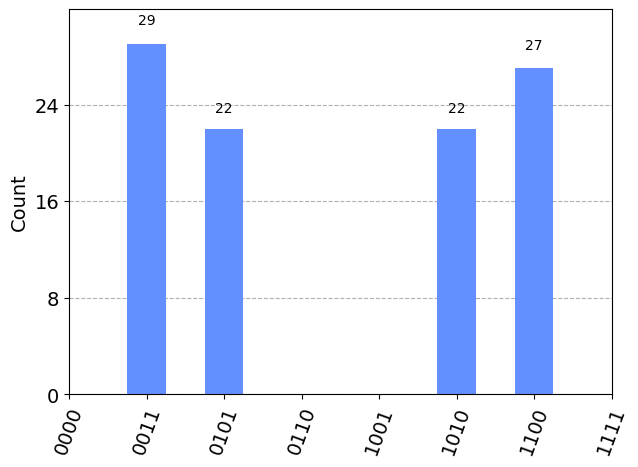

In [23]:
#Visualize the result
result_final=run_iteration(circuit_ansatz(n, result.x, conn,layers,ansatz_type), shots)
plot_histogram(result_final)

Next let's test it on the qpu backend.

In [ ]:
#Train Circuit
backend = provider.get_backend("ionq_qpu")
result=noisyopt.minimizeSPSA(run_circuit_and_calc_cost, params, args=args, bounds=bnds, niter=max_iter, disp=False, paired=False)

print("Success: ", result.success)
print(result.message)
print("Final cost function is ", result.fun)
print("Min possible cost function is ", np.log2(len(target_states)))
print("Number of iterations is ", result.nit)
print("Number of function evaluations is ", result.nfev)
print("Number of parameters was ", len(params))
print("Approximate cost on hardware: $", 0.01*len(cost_history)*shots)

#Plot the evolution of the cost function
plt.figure()
plt.plot(cost_history)
plt.ylabel('Cost')
plt.xlabel('Iteration')

Current cost: 10.761890427446444
Current cost: 4.124652290512016
Current cost: 3.781053411816642
Current cost: 4.382757659935111
Current cost: 4.01641243869299
Current cost: 4.319054185177905


In [2]:
#Visualize the result
result_final=run_iteration(circuit_ansatz(n, result.x, conn,layers,ansatz_type), shots)
plot_histogram(result_final)

NameError: ignored